In [14]:
import torch
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

class verify_theoretical_var:
    
    def __init__(self, data, sigma, n):
        self.data = data
        self.sigma = sigma
        self.n = n
        self.p = data.shape[1] - 1
        self.Z_hat = data[:n, : self.p]
        self.Z = self.Z_hat + self.noise()
        
    def noise(self):
        normal = Normal(0, self.sigma)
        noise = normal.sample((self.n, self.p))
        return(noise)
    
    # Suppose the latent model is Z = Z_hat W
    
    def OLS_sol_W(self):
        
        # # Option 1: Direct Computation
        # W_hat = torch.linalg.solve(self.Z_hat.T @ self.Z_hat, self.Z_hat.T @ self.Z )
        
        # # Option 2: sklearn linear regression
        # model = LinearRegression(fit_intercept=False)
        # model.fit(self.Z_hat, self.Z)
        # W_hat = torch.as_tensor(model.coef_)
        
        # Option 3: torch.linalg.lstsq
        model = torch.linalg.lstsq(self.Z_hat, self.Z)
        W_hat = model.solution
        
        return(W_hat)
    
    def OLS_sol_var(self):

        theo_var = np.square(self.sigma) * (torch.linalg.inv(self.Z_hat.T @ self.Z_hat))
        
        return(theo_var)
    




def simulate_var(num_iter, data, sigma, n):
    W_hat_list = []
    for i in range(num_iter):
        mod = verify_theoretical_var(data, sigma, n)

        W_hat_list.append(mod.OLS_sol_W())
    
    W_hat_tensor = torch.stack(W_hat_list)
    W_compwise_var = torch.var(W_hat_tensor, dim = 0)
    # W_var_col_1 = W_compwise_var[:, 0]
    # W_var_col_2 = W_compwise_var[:, 1]
    emp_var_diag = torch.diag(W_compwise_var)
    theo_var = mod.OLS_sol_var()
    
    # return(W_var_col_1, W_var_col_2, theo_var_avg)
    return(emp_var_diag, theo_var)


In [11]:
num_iter, sigma, n_max  = 10000, 0.01, 100000
# alpha = [[10,1,1], [1,10,1], [1,1,10]]
# fixed_Z = sim.ABC.init_Z(30000, torch.as_tensor(alpha, dtype = torch.float32))

fixed_Z = torch.rand(n_max, 3)

results = []
for n in range(10000, n_max+1, 5000):
    
    emp_var_col_diag, theo_var_avg = simulate_var(num_iter, fixed_Z, sigma, n)
    theo_var_diag = torch.diag(theo_var_avg)
    
    p = fixed_Z.shape[1] - 1
    for coef in range(1, (p+1)):
        results.append({
            "n": n,
            "coef": coef,
            "emp_var_diag": emp_var_col_diag[coef-1].item(),
            "theo_var": theo_var_diag[coef-1].item()
        })
    sys.stdout.write(f"\r Just finished n = {n}    ")
    sys.stdout.flush()
    
# Create the DataFrame.
df = pd.DataFrame(results)
df.to_csv(r"temp_df/ols_sol_var.csv")

 Just finished n = 100000    

Using Option 1: Direct Computation dtype = torch.float64

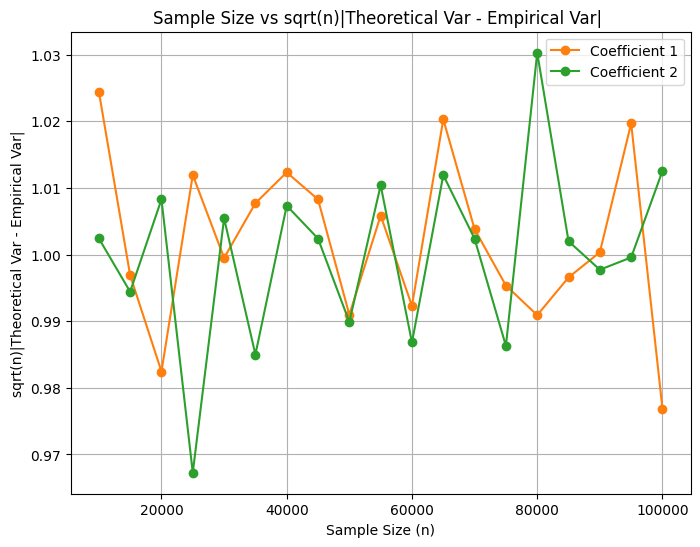

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv(r"temp_df/ols_sol_var.csv")
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors  # distinct colors for different coefficients

# Loop over each unique coefficient in the DataFrame.
for coef in sorted(df['coef'].unique()):
    sub_df = df[df['coef'] == coef].copy()
    # Compute the ratio of theoretical to empirical variance.
    # sub_df['ratio'] = np.abs(sub_df['theo_var'] - sub_df['emp_var_diag']) * np.sqrt(sub_df['n'])
    sub_df['ratio'] = sub_df['theo_var']/sub_df['emp_var_diag']
    
    plt.plot(sub_df['n'], sub_df['ratio'], marker='o', linestyle='-', 
             label=f"Coefficient {coef}", color=colors[coef % len(colors)])

plt.xlabel("Sample Size (n)")
plt.ylabel("sqrt(n)|Theoretical Var - Empirical Var|")
plt.title("Sample Size vs sqrt(n)|Theoretical Var - Empirical Var| ")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df

,Unnamed: 0,n,coef,emp_var_diag,theo_var
0,0,10000,1,7.148874e-08,6.779012e-08
1,1,10000,2,6.645658e-08,6.837802e-08
2,2,60000,1,1.141523e-08,1.137485e-08
3,3,60000,2,1.158691e-08,1.137660e-08
4,4,110000,1,6.467852e-09,6.226338e-09
5,5,110000,2,6.604149e-09,6.230931e-09
6,6,160000,1,4.195884e-09,4.301604e-09
7,7,160000,2,4.357036e-09,4.281519e-09
8,8,210000,1,3.419841e-09,3.271048e-09
9,9,210000,2,3.434802e-09,3.261738e-09


Result from sklearn linear regression

 Just finished n = 1000000    

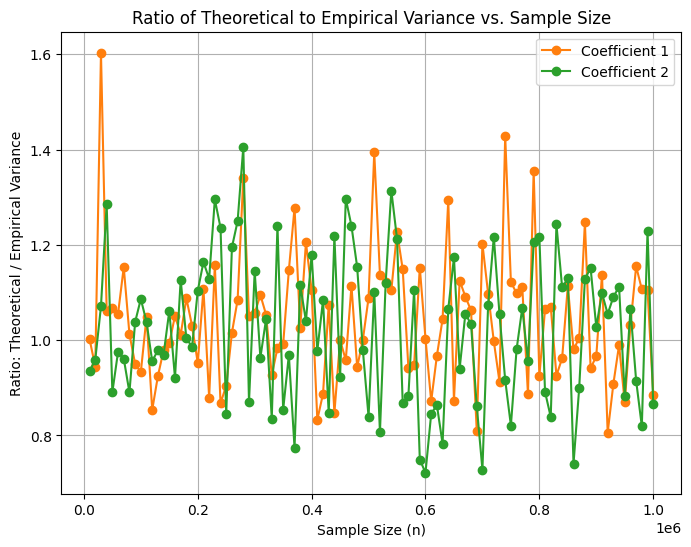

In [10]:
num_iter, sigma, n_max  = 100, 0.025, 1000000

fixed_Z = torch.rand(n_max, 3)

results = []
for n in range(10000, n_max+1, 10000):
    
    emp_var_diag, theo_var_avg = simulate_var(num_iter, fixed_Z, sigma, n)
    theo_var_diag = torch.diag(theo_var_avg)
    
    p = fixed_Z.shape[1] - 1
    for coef in range(1, (p+1)):
        results.append({
            "n": n,
            "coef": coef,
            "emp_var_diag": emp_var_diag[coef-1].item(),
            "theo_var": theo_var_diag[coef-1].item()
        })
    sys.stdout.write(f"\r Just finished n = {n}    ")
    sys.stdout.flush()
    
# Create the DataFrame.
df = pd.DataFrame(results)
df.to_csv(r"temp_df/ols_sol_small_var.csv")


plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors  # distinct colors for different coefficients

# Loop over each unique coefficient in the DataFrame.
for coef in sorted(df['coef'].unique()):
    sub_df = df[df['coef'] == coef].copy()
    # Compute the ratio of theoretical to empirical variance.
    sub_df['ratio'] = sub_df['theo_var'] / sub_df['emp_var_diag']
    
    plt.plot(sub_df['n'], sub_df['ratio'], marker='o', linestyle='-', 
             label=f"Coefficient {coef}", color=colors[coef % len(colors)])

plt.xlabel("Sample Size (n)")
plt.ylabel("Ratio: Theoretical / Empirical Variance")
plt.title("Ratio of Theoretical to Empirical Variance vs. Sample Size")
plt.legend()
plt.grid(True)
plt.show()